In [1]:
from math import factorial, exp
import matplotlib.pyplot as plt
import numpy as np
import csv
import time

def offeredTraffic(calls_per_hour, hours_per_call): # A0
    return calls_per_hour*hours_per_call

def erlangB(n, A0):
    denom = 0
    for i in range(n+1):
        denom += (A0**i)/(factorial(i))
    E1 = ((A0**n)/factorial(n))/denom
    return E1

# def erlangC(n, A0):
#     denom = ((A0**n)/factorial(n))*(n/(n-A0))
#     for i in range(n):
#         denom += (A0**i)/factorial(i)
#     return ((A0**n)/factorial(n))*(n/(n-A0))/denom

def erlangC(n, A0):
    denomSum = 0
    for i in range(n):
        denomSum += (A0**i)/factorial(i)
    denom = A0**n + factorial(n)*(1-A0/n)*denomSum
    return (A0**n)/denom

def meanCallDelay(n, A0, meanCallDuration, probDelay):
    # print(probDelay)
    return probDelay*meanCallDuration/(n-A0)

def meanQueuedDelay(n, A0, meanCallDuration):
    return meanCallDuration/(n-A0)

def erlangC_allowedDelayGOS(n, A0, meanCallDuration, allowedDelay=0):
    probDelay = erlangC(n,A0)
    return probDelay*exp(-(n-A0)*allowedDelay/meanCallDuration)


In [76]:
def trafficSimulation(numChannels, numCalls, meanCallDuration, requeue=False, recheckChannelsDelay=0, allowedDelay=0, holdingDistrib='exp', repetitions=1):

    callFailRates = np.zeros(repetitions)
    meanCallDelay = np.zeros(repetitions)

    for i in range(repetitions):

        if holdingDistrib == 'exp':
            callDurations = np.random.exponential(scale=meanCallDuration, size=numCalls)

        elif holdingDistrib == 'gamma':
            # callDurations = np.random.gamma(shape=1, scale=meanCallDuration, size=numCalls)
            callDurations = np.random.gamma(shape=1.2073, scale=0.03205, size=numCalls)  # shape from paper, scale from paper: 0.03205 = muCHT*(muPaper/bPaper) = muCHT * (29.6121/35.875)

        callStarts = np.random.uniform(size=numCalls)
        # callStarts = np.random.poisson(lam=1/(meanCallDuration*3600), size=numCalls)
        # plt.hist(callStarts, 50)
        # plt.show()
        callStarts.sort()

        # Calls = Numpy array of [[call0_start call0_end]; [call1_start call1_end];...
        calls = np.stack((callStarts, np.add(callStarts,callDurations)),axis=1)

        channelFreeTimes = np.zeros(numChannels)
        time = 0
        callsFailed = 0
        totalDelay = 0
        for call in calls:
            time = call[0]
            channelFound = False

            for j in range(numChannels):
                if not(channelFound):
                    if channelFreeTimes[j] <= time:
                        channelFreeTimes[j] = call[1]
                        channelFound = True

            if channelFound == False:
                if requeue == False:
                    callsFailed += 1

        ## add max wait time?_______________________
                elif recheckChannelsDelay > 0:
                    callsFailed += 1
                    while channelFound == False:
                        time += recheckChannelsDelay
                        totalDelay += recheckChannelsDelay

                        call[1] += recheckChannelsDelay # move forward call end time
                        for j in range(numChannels):
                            if not(channelFound): # Stop checking channels as soon as a free one is found
                                if channelFreeTimes[j] <= time:
                                    channelFreeTimes[j] = call[1]
                                    channelFound = True
                        
                else:
                    nextCallFinishTime = channelFreeTimes.min()
                    totalDelay += nextCallFinishTime-call[0]
                    call[1] += nextCallFinishTime-call[0]
                    if nextCallFinishTime-call[0]>allowedDelay: # only count call as failed if above the allowed wait time (if allowance present)
                        callsFailed += 1
                    indices = np.where(channelFreeTimes == nextCallFinishTime)
                    index = indices[0][0]
                    channelFreeTimes[index] = call[1]

        callFailRates[i] = callsFailed/numCalls
        meanCallDelay[i] = totalDelay/numCalls

    if requeue == False:
        return callFailRates.mean(), np.std(callFailRates, ddof=1)
    else:
        return callFailRates.mean(), np.std(callFailRates, ddof=1), meanCallDelay.mean(), np.std(meanCallDelay, ddof=1)

In [33]:
meanCallDuration = 2.33/60# 2.33 mins in hrs
n = 57

# simulationCallAmounts = np.linspace(100, 3000, 30).astype(np.int)
# simulationCallAmounts = np.linspace(0, 2000, 81).astype(np.int)
simulationCallAmounts = (np.linspace(1, 100, 50)/meanCallDuration).astype(np.int)
A0s = offeredTraffic(simulationCallAmounts, meanCallDuration)
repetitionsPerSimulation = 100
print(simulationCallAmounts, A0s)

[  25   77  129  181  233  285  337  389  441  494  546  598  650  702
  754  806  858  910  962 1014 1066 1118 1170 1222 1274 1326 1378 1430
 1482 1534 1586 1638 1690 1742 1794 1846 1898 1950 2002 2054 2106 2158
 2210 2262 2314 2366 2419 2471 2523 2575] [ 0.97083333  2.99016667  5.0095      7.02883333  9.04816667 11.0675
 13.08683333 15.10616667 17.1255     19.18366667 21.203      23.22233333
 25.24166667 27.261      29.28033333 31.29966667 33.319      35.33833333
 37.35766667 39.377      41.39633333 43.41566667 45.435      47.45433333
 49.47366667 51.493      53.51233333 55.53166667 57.551      59.57033333
 61.58966667 63.609      65.62833333 67.64766667 69.667      71.68633333
 73.70566667 75.725      77.74433333 79.76366667 81.783      83.80233333
 85.82166667 87.841      89.86033333 91.87966667 93.93783333 95.95716667
 97.9765     99.99583333]


# Calls:	Traffic:	Erlang B:		Sim GOS (exp):		stdDev (exp):		Sim GOS (gamma)		stdDev (gamma):
25		0.9708		0.0000			0.0000			0.0000			0.0000			0.0000
161		6.2522		0.0000			0.0000			0.0000			0.0000			0.0000
297		11.5335		0.0000			0.0000			0.0000			0.0000			0.0000
434		16.8537		0.0000			0.0000			0.0000			0.0000			0.0000
570		22.1350		0.0000			0.0000			0.0000			0.0000			0.0000
706		27.4163		0.0000			0.0000			0.0000			0.0000			0.0000
842		32.6977		0.0033			0.0024			0.0167			0.0000			0.0000
978		37.9790		0.0857			0.0491			0.1398			0.0000			0.0000
1114		43.2603		0.7410			0.6158			0.6401			0.0000			0.0000
1250		48.5417		2.9239			2.6344			1.0580			0.0000			0.0000
1386		53.8230		6.8968			6.1299			1.6612			0.0000			0.0000
1522		59.1043		11.9388			10.9625			1.4760			0.0000			0.0000
1659		64.4245		17.2882			15.9681			1.5659			0.0000			0.0000
1795		69.7058		22.4059			21.3170			1.6257			0.0000			0.0000
1931		74.9872		27.1444			25.8856			1.6448			0.0000			0.0000


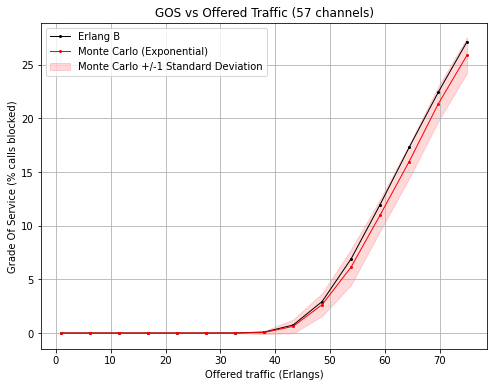

10.556500434875488


In [41]:
# CALLS BLOCKED - NO REQUEUING
startTime= time.time()
meanCallDuration = 2.33/60# 2.33 mins in hrs
n = 57

simulationCallAmounts = (np.linspace(1, 75, 15)/meanCallDuration).astype(np.int)
A0s = offeredTraffic(simulationCallAmounts, meanCallDuration)
repetitionsPerSimulation = 100

erlangBs = np.zeros(simulationCallAmounts.shape)
GOS_exp = np.zeros(simulationCallAmounts.shape)
stdDevs_exp = np.zeros(simulationCallAmounts.shape)
GOS_gamma = np.zeros(simulationCallAmounts.shape)
stdDevs_gamma = np.zeros(simulationCallAmounts.shape)

print("# Calls:\tTraffic:\tErlang B:\t\tSim GOS (exp):\t\tstdDev (exp):\t\tSim GOS (gamma)\t\tstdDev (gamma):")
for i, numCalls in enumerate(simulationCallAmounts):

    A0 = A0s[i]#offeredTraffic(numCalls, meanCallDuration)
    erlangBs[i] = erlangB(n, A0)*100

    meanBlockingRate_exp, stdDev_exp = trafficSimulation(n, numCalls, meanCallDuration, holdingDistrib='exp', repetitions=repetitionsPerSimulation)
    GOS_exp[i] = meanBlockingRate_exp*100
    stdDevs_exp[i] = stdDev_exp*100

#     meanBlockingRate_gamma, stdDev_gamma = trafficSimulation(n, numCalls, meanCallDuration, holdingDistrib='gamma', repetitions=repetitionsPerSimulation)
#     GOS_gamma[i] = meanBlockingRate_gamma*100
#     stdDevs_gamma[i] = stdDev_gamma*100

    print("{}\t\t{:.4f}\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}".format(numCalls, A0, erlangBs[i], GOS_exp[i], stdDevs_exp[i], GOS_gamma[i], stdDevs_gamma[i]))

plt.figure(figsize=(8,6))
markerSize=2
lineWidth=1
plt.plot(A0s, erlangBs, label='Erlang B', color="black", marker='o', markersize=markerSize, linewidth=lineWidth)

plt.plot(A0s, GOS_exp, label="Monte Carlo (Exponential)", color="red", marker='o', markersize=markerSize, linewidth=lineWidth)
# plt.errorbar(trafficRange, GOS_exp, yerr=stdDevs_exp, label="Monte Carlo (Exponential)", color="red")
plt.fill_between(A0s, GOS_exp+stdDevs_exp, GOS_exp-stdDevs_exp, interpolate=True, color="red", alpha=0.15, label="Monte Carlo +/-1 Standard Deviation")

# plt.errorbar(trafficRange, GOS_gamma, yerr=stdDevs_gamma, label="Gamma", color="green")
# plt.fill_between(trafficRange, GOS_gamma+stdDevs_gamma, GOS_gamma-stdDevs_gamma, interpolate=True, color="green", alpha=0.2)

plt.xlabel('Offered traffic (Erlangs)')
plt.ylabel('Grade Of Service (% calls blocked)')
plt.title("GOS vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.grid()
plt.savefig("sim1.png")
plt.show()

timeTaken = time.time()-startTime
print(timeTaken)

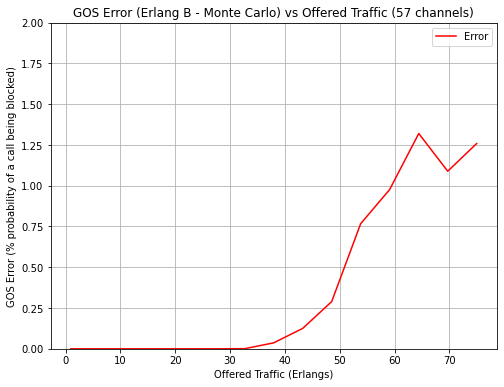

In [44]:
# ERROR
error = erlangBs-GOS_exp

plt.figure(figsize=(8,6))
plt.plot(A0s, error, label="Error", color='red')
# plt.vlines(x = A0s[n//2], ymin = 0, ymax = error[n//2], color = 'blue', label = 'Offered Traffic = 57 = # channels', linewidth=1)

plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('GOS Error (% probability of a call being blocked)')
plt.title("GOS Error (Erlang B - Monte Carlo) vs Offered Traffic ({} channels)".format(n))
plt.ylim([0,2])
plt.legend()
plt.grid()
plt.savefig('sim1_2.png')
plt.show()

44.20451851694091 42.8381359223301


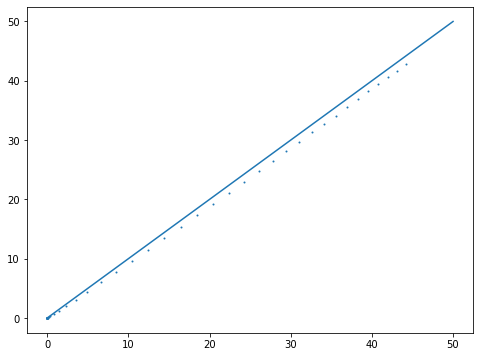

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(erlangBs, GOS_exp, 1, vmin=0, vmax=1)
print(erlangBs[49], GOS_exp[49])
plt.plot([0,50],[0,50])
plt.show()

[  25   51   77  103  128  154  180  206  231  257  283  309  334  360
  386  412  437  463  489  515  540  566  592  618  643  669  695  721
  746  772  798  824  849  875  901  927  952  978 1004 1030 1055 1081
 1107 1133 1158 1184 1210 1236 1261 1287 1313 1339 1364 1390 1416 1442
 1467 1493] [ 0.97083333  1.9805      2.99016667  3.99983333  4.97066667  5.98033333
  6.99        7.99966667  8.9705      9.98016667 10.98983333 11.9995
 12.97033333 13.98       14.98966667 15.99933333 16.97016667 17.97983333
 18.9895     19.99916667 20.97       21.97966667 22.98933333 23.999
 24.96983333 25.9795     26.98916667 27.99883333 28.96966667 29.97933333
 30.989      31.99866667 32.9695     33.97916667 34.98883333 35.9985
 36.96933333 37.979      38.98866667 39.99833333 40.96916667 41.97883333
 42.9885     43.99816667 44.969      45.97866667 46.98833333 47.998
 48.96883333 49.9785     50.98816667 51.99783333 52.96866667 53.97833333
 54.988      55.99766667 56.9685     57.97816667]


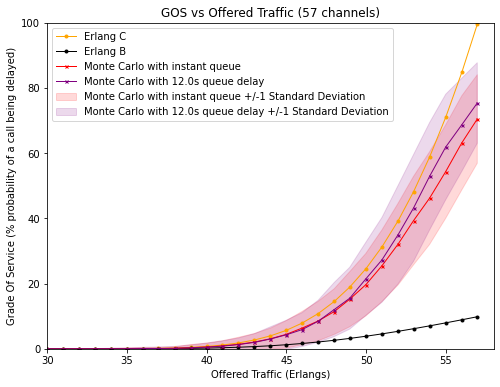

0.46000146865844727


In [89]:
# WITH REQUEUING
startTime = time.time()

meanCallDuration = 2.33/60# 2.33 mins in hrs
n = 57

simulationCallAmounts = (np.linspace(1, n, n)/meanCallDuration).astype(np.int)
A0s = offeredTraffic(simulationCallAmounts, meanCallDuration)
repetitionsPerSimulation = 1000

# print(simulationCallAmounts, A0s)

# erlangBs = np.zeros(simulationCallAmounts.shape)
# erlangCs = np.zeros(simulationCallAmounts.shape)
# meanCallDelays_calc = np.zeros(simulationCallAmounts.shape)

# qGOS_exp = np.zeros(simulationCallAmounts.shape)
# qStdDevs_exp = np.zeros(simulationCallAmounts.shape)
# meanCallDelays_exp = np.zeros(simulationCallAmounts.shape)
# callDelayStdDevs_exp = np.zeros(simulationCallAmounts.shape)

# qGOS_exp_delayed = np.zeros(simulationCallAmounts.shape)
# qStdDevs_exp_delayed = np.zeros(simulationCallAmounts.shape)
# meanCallDelays_exp_delayed = np.zeros(simulationCallAmounts.shape)
# callDelayStdDevs_exp_delayed = np.zeros(simulationCallAmounts.shape)

# # GOS_gamma = np.zeros(simulationCallAmounts.shape)
# # stdDevs_gamma = np.zeros(simulationCallAmounts.shape)
# # meanCallDelays_gamma = np.zeros(simulationCallAmounts.shape)
# # callDelayStdDevs_gamma = np.zeros(simulationCallAmounts.shape)

# allowedDelay = 0 # (in hours)
# recheckDelay = 0.2/60 # (in hours)

# print("# Calls:\tTraffic:\tErlang C:\t\tSim GOS (exp):\t\tSim GOS stdDev\t\tCalc. delay/call\tSim Mean delay/call\tdelay/call stdDev")
# for i, numCalls in enumerate(simulationCallAmounts):

#     A0 = A0s[i]
#     erlangBs[i] = erlangB(n, A0)*100
#     erlangCs[i] = erlangC_allowedDelayGOS(n, A0, meanCallDuration, allowedDelay=allowedDelay)*100
#     # meanCallDelays_calc[i] = meanCallDelay(n, A0, meanCallDuration, np.clip(erlangCs/100,0,1)[i])

#     meanDelayRate_exp, stdDev_exp,  meanCallDelay_exp, callDelayStdDev_exp = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, recheckChannelsDelay=0, repetitions=repetitionsPerSimulation)
#     qGOS_exp[i] = meanDelayRate_exp*100
#     qStdDevs_exp[i] = stdDev_exp*100
#     meanCallDelays_exp[i] = meanCallDelay_exp
#     callDelayStdDevs_exp[i] = callDelayStdDev_exp
    
#     meanDelayRate_exp_delayed, stdDev_exp_delayed,  meanCallDelay_exp_delayed, callDelayStdDev_exp_delayed = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, recheckChannelsDelay=recheckDelay, repetitions=repetitionsPerSimulation)
#     qGOS_exp_delayed[i] = meanDelayRate_exp_delayed*100
#     qStdDevs_exp_delayed[i] = stdDev_exp_delayed*100
#     meanCallDelays_exp_delayed[i] = meanCallDelay_exp_delayed
#     callDelayStdDevs_exp_delayed[i] = callDelayStdDev_exp_delayed

#     # meanDelayRate_gamma, stdDev_gamma,  meanCallDelay_gamma, callDelayStdDev_gamma = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, recheckChannelsDelay=recheckDelay, allowedDelay=allowedDelay, holdingDistrib='gamma', repetitions=repetitionsPerSimulation)
#     # GOS_gamma[i] = meanDelayRate_gamma*100
#     # stdDevs_gamma[i] = stdDev_gamma*100
#     # meanCallDelays_gamma[i] = meanCallDelay_gamma
#     # callDelayStdDevs_gamma[i] = callDelayStdDev_gamma

#     print("{}\t\t{:.4f}\t\t\t{:.3f}\t\t\t{:.3f}\t\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}".format(numCalls, A0, erlangCs[i], qGOS_exp[i], qStdDevs_exp[i], meanCallDelays_calc[i], meanCallDelays_exp[i], callDelayStdDevs_exp[i]))


plt.figure(figsize=(8,6))
markerSize = 3
lineWidth = 1
plt.plot(A0s, np.clip(erlangCs,0,100), label='Erlang C', color="orange", marker='o', markersize=markerSize, linewidth=lineWidth)
plt.plot(A0s, erlangBs, label='Erlang B', color="black", marker='o', markersize=markerSize, linewidth=lineWidth)
plt.plot(A0s, qGOS_exp, label="Monte Carlo with instant queue", color="red", marker='x', markersize=markerSize, linewidth=lineWidth)
plt.fill_between(A0s, qGOS_exp+qStdDevs_exp,  qGOS_exp-qStdDevs_exp, interpolate=True, color="red", alpha=0.15, label="Monte Carlo with instant queue +/-1 Standard Deviation")
# plt.errorbar(A0s, qGOS_exp, yerr=qStdDevs_exp, label="Monte Carlo with requeue (Exponential)", color="red")
plt.plot(A0s, qGOS_exp_delayed, label="Monte Carlo with {}s queue delay".format(recheckDelay*3600), color="purple", marker='x', markersize=markerSize, linewidth=lineWidth)
plt.fill_between(A0s, qGOS_exp_delayed+qStdDevs_exp_delayed,  qGOS_exp_delayed-qStdDevs_exp_delayed, interpolate=True, color="purple", alpha=0.15, label="Monte Carlo with {}s queue delay +/-1 Standard Deviation".format(recheckDelay*3600))
# plt.errorbar(A0s, GOS_gamma, yerr=stdDevs_gamma, label="Monte Carlo with requeue (Gamma)", color="green")
# plt.fill_between(A0s, GOS_gamma+stdDevs_gamma, GOS_gamma-stdDevs_gamma, interpolate=True, color="green", alpha=0.15)
# plt.vlines(x = n, ymin = 0, ymax = 100, color = 'blue', label = 'Offered Traffic = n channels')
plt.xlim([30,58])
plt.ylim([0,100])
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('Grade Of Service (% probability of a call being delayed)')
# plt.ylabel('Grade Of Service (% probability of a call being delayed for > {} sec)'.format(allowedDelay*3600))
plt.title("GOS vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.savefig("sim1.png")
plt.show()

timeTaken = time.time()-startTime
print(timeTaken)

In [ ]:
# ERROR
qError = np.clip(erlangCs,0,100)-qGOS_exp
trafficRange = offeredTraffic(simulationCallAmounts,meanCallDuration)

plt.figure(figsize=(8,5))
print(qError)
# plt.hist(qError, 35, density=True)
plt.vlines(x = n, ymin = 0, ymax = 30, color = 'red', label = 'Offered Traffic = n channels')
plt.plot(trafficRange, qError, label="Error")
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('GOS Error (% probability of a call being delayed)')
plt.title("GOS Error vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.show()

qAbsError = np.abs(qError)
plt.figure(figsize=(8,5))
plt.vlines(x = n, ymin = 0, ymax = 30, color = 'red', label = 'Offered Traffic = n channels')
plt.ylim([0,28])
plt.plot(trafficRange, qAbsError)
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('GOS Absolute Error (% probability of a call being delayed)')
plt.title("GOS Absolute Error vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.show()

In [ ]:
simulationCallAmounts = (np.linspace(46, 56, 21)/meanCallDuration).astype(np.int)
repetitionsPerSimulation = 500
print(simulationCallAmounts)

erlangCs = np.zeros(simulationCallAmounts.shape)
meanCallDelays_calc = np.zeros(simulationCallAmounts.shape)

meanCallDelays_exp = np.zeros(simulationCallAmounts.shape)
callDelayStdDevs_exp = np.zeros(simulationCallAmounts.shape)

allowedDelay = 0 # (in hours)
recheckDelay = 0 #20/3600 # (in hours)

print("# Calls\t\tTraffic:\tCalc. delay/call\tSim Mean delay/call\tdelay/call stdDev")
for i, numCalls in enumerate(simulationCallAmounts):

    A0 = offeredTraffic(numCalls, meanCallDuration)
    
    erlangCs[i] = erlangC_allowedDelayGOS(n, A0, meanCallDuration, allowedDelay=allowedDelay)
    
    meanCallDelays_calc[i] = meanCallDelay(n, A0, meanCallDuration, erlangCs[i])*3600

    _, _,  meanCallDelay_exp, callDelayStdDev_exp = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, recheckChannelsDelay=recheckDelay,  holdingDistrib='exp', repetitions=repetitionsPerSimulation)
    meanCallDelays_exp[i] = meanCallDelay_exp*3600
    callDelayStdDevs_exp[i] = callDelayStdDev_exp*3600
    print("{}\t\t{:.3f}\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}".format(numCalls, A0, meanCallDelays_calc[i], meanCallDelays_exp[i], callDelayStdDevs_exp[i]))

plt.figure(figsize=(12,6))
trafficRange = offeredTraffic(simulationCallAmounts,meanCallDuration)
plt.plot(trafficRange, np.clip(meanCallDelays_calc,0,100), label='Erlang C Calculated Delay', color="orange")
plt.errorbar(trafficRange, meanCallDelays_exp, yerr=callDelayStdDevs_exp, label="Monte Carlo with requeue (Exponential)", color="red")
plt.fill_between(trafficRange, meanCallDelays_exp+callDelayStdDevs_exp, meanCallDelays_exp-callDelayStdDevs_exp, interpolate=True, color="red", alpha=0.15)
# plt.xlim([30,60])
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('Mean Delay/Call (seconds)')
plt.title("Mean Delay per Call vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.show()

duration1 = meanCallDelays_exp
error1 = callDelayStdDevs_exp

# Calls		Traffic:	Calc. delay/call	Sim Mean delay/call	delay/call stdDev
0.0
25		0.971		0.0000			0.0000			0.0000
0.0
51		1.981		0.0000			0.0000			0.0000
0.0
77		2.990		0.0000			0.0000			0.0000
0.0
103		4.000		0.0000			0.0000			0.0000
0.0
128		4.971		0.0000			0.0000			0.0000
0.0
154		5.980		0.0000			0.0000			0.0000
0.0
180		6.990		0.0000			0.0000			0.0000
0.0
206		8.000		0.0000			0.0000			0.0000
0.0
231		8.971		0.0000			0.0000			0.0000
0.0
257		9.980		0.0000			0.0000			0.0000
0.0
283		10.990		0.0000			0.0000			0.0000
0.0
309		12.000		0.0000			0.0000			0.0000
0.0
334		12.970		0.0000			0.0000			0.0000
0.0
360		13.980		0.0000			0.0000			0.0000
0.0
386		14.990		0.0000			0.0000			0.0000
0.0
412		15.999		0.0000			0.0000			0.0000
0.0
437		16.970		0.0000			0.0000			0.0000
0.0
463		17.980		0.0000			0.0000			0.0000
0.0
489		18.990		0.0000			0.0000			0.0000
0.0
515		19.999		0.0000			0.0000			0.0000
0.0
540		20.970		0.0000			0.0000			0.0000
0.0
566		21.980		0.0000			0.0000			0.0000
0.0
592		22.989	

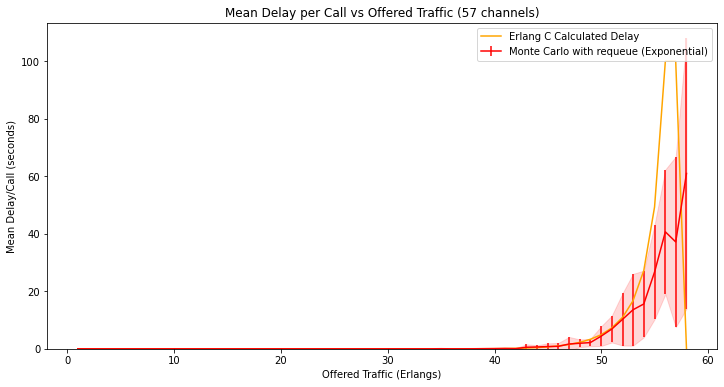

In [73]:
erlangCs = np.zeros(simulationCallAmounts.shape)
meanCallDelays_calc = np.zeros(simulationCallAmounts.shape)

meanCallDelays_exp = np.zeros(simulationCallAmounts.shape)
callDelayStdDevs_exp = np.zeros(simulationCallAmounts.shape)

allowedDelay = 0 # (in hours)
recheckDelay = 5/3600 # (in hours)

print("# Calls\t\tTraffic:\tCalc. delay/call\tSim Mean delay/call\tdelay/call stdDev")
for i, numCalls in enumerate(simulationCallAmounts):

    A0 = offeredTraffic(numCalls, meanCallDuration)
    
    erlangCs[i] = erlangC_allowedDelayGOS(n, A0, meanCallDuration, allowedDelay=allowedDelay)
    
    meanCallDelays_calc[i] = meanCallDelay(n, A0, meanCallDuration, erlangCs[i])*3600

    _, __,  meanCallDelay_exp, callDelayStdDev_exp = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, recheckChannelsDelay=recheckDelay,  holdingDistrib='exp', repetitions=repetitionsPerSimulation)
    print(_)
    meanCallDelays_exp[i] = meanCallDelay_exp*3600
    callDelayStdDevs_exp[i] = callDelayStdDev_exp*3600
    print("{}\t\t{:.3f}\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}".format(numCalls, A0, meanCallDelays_calc[i], meanCallDelays_exp[i], callDelayStdDevs_exp[i]))

plt.figure(figsize=(12,6))
trafficRange = offeredTraffic(simulationCallAmounts,meanCallDuration)
plt.plot(trafficRange, np.clip(meanCallDelays_calc,0,100), label='Erlang C Calculated Delay', color="orange")
plt.errorbar(trafficRange, meanCallDelays_exp, yerr=callDelayStdDevs_exp, label="Monte Carlo with requeue (Exponential)", color="red")
plt.fill_between(trafficRange, meanCallDelays_exp+callDelayStdDevs_exp, meanCallDelays_exp-callDelayStdDevs_exp, interpolate=True, color="red", alpha=0.15)
plt.ylim(bottom=0)
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('Mean Delay/Call (seconds)')
plt.title("Mean Delay per Call vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.show()

duration2 = meanCallDelays_exp
error2 = callDelayStdDevs_exp

In [ ]:
plt.plot(trafficRange, duration1, label="no delay", color='red')
plt.fill_between(trafficRange, duration1+error1, duration1-error1, interpolate=True, color="red", alpha=0.18)

plt.plot(trafficRange, duration2, label="5s delay")
plt.fill_between(trafficRange, duration2+error2, duration2-error2, interpolate=True, color="blue", alpha=0.18)

# plt.ylim([0,5])
plt.legend()
plt.show()
print(duration1.mean(), duration2.mean())
print(error1.mean(), error2.mean())

In [ ]:
with open('block.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["# Calls", "Offered Traffic", "Erlang B:", "Sim GOS (exponential):", "Sim std dev (exponential):", "Repetitions per simulation = "+str(repetitionsPerSimulation)])
    # (numCalls, A0, erlangBs[i], GOS_exp[i], stdDevs_exp[i],
    for i, numCalls in enumerate(simulationCallAmounts):
        writer.writerow([numCalls, A0s[i], erlangBs[i], GOS_exp[i], stdDevs_exp[i]])